# NLP_GoingDeeper | P10.Transformer_Translation_Kor2Eng
---
- 한국어 문장을 입력으로 하여 영어로 번역된 문장을 출력하는 번역기를 만들어봅니다. 

아래 링크에서 **korean-english-park.train.tar.gz** 를 사용할 예정입니다.

**링크 : https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1**

AIFFEL 클라우드 환경에서 작업이 진행되므로, 별도의 설치 없이 사전에 준비되어 있는 한국어-영어 데이터쌍을 사용합니다.

미리 준비되어 있는 데이터를 연결하기 위해, 아래와 같이 공유 디렉토리에 저장된 데이터를 가리키는 심볼릭 링크를 생성합니다.

In [1]:
# 내가 시간을 측정하는 이유는 각 GPU환경에 따른 모델 속도 비교.
import time
start_time = time.time()

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = 'C:/Users/Noah/AppData/Local/Microsoft/Windows/Fonts/NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumGothic')
mpl.font_manager.findfont(font)
print("완료!")

완료!


In [3]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import sentencepiece as spm
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from tqdm import tqdm
from tqdm import tqdm_notebook
import random


print(tf.__version__)

2.8.0


In [4]:
data_dir = 'C:/Users/Noah/aiffel/GoingDeeper/AIFFEL_GOINGDEEPER_NLP/G-10/datasets'
kor_path = data_dir + "/korean-english-park.train.ko"
eng_path = data_dir + "/korean-english-park.train.en"

In [5]:
with open(kor_path, "r",encoding='utf8') as f: kor = f.read().splitlines()
with open(eng_path, "r",encoding='utf8') as f: eng = f.read().splitlines()
print("Data Size:({},{})".format(len(kor), len(eng)))
print("Example:")

cnt = 0
for ko, en in zip(kor, eng):
    print(f">>\n한국어 : {ko}\n영어 : {en}\n")
    cnt += 1
    if cnt == 5:
        break

Data Size:(94123,94123)
Example:
>>
한국어 : 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
영어 : Much of personal computing is about "can you top this?"

>>
한국어 : 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
영어 : so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.

>>
한국어 : 그러나 이것은 또한 책상도 필요로 하지 않는다.
영어 : Like all optical mice, But it also doesn't need a desk.

>>
한국어 : 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
영어 : uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.

>>
한국어 : 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
영어 : Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror atta

# 2. 데이터 정제 및 토큰화 
### 1) 중복데이터 제거
- set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거합니다. 
- 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [6]:
# 데이터 정제 및 토큰화
def clean_corpus(kor, eng):
    assert len(kor) == len(eng)
    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

In [7]:
cleaned_corpus = clean_corpus(kor, eng)
len(cleaned_corpus)

78968

### 2) 정제함수 정의

- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다.
- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [8]:
def preprocess_sentence(sentence):
    sentence = sentence.lower() #- 소문자 변환
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence) #- 알파벳, 문장부호, 한글 이외는 제거
    sentence = re.sub(r'[" "]+', " ", sentence) #- 여러개의 공백은 하나의 공백으로 바꾸기
    sentence = sentence.strip() #- 양쪽 공백 제거
    return sentence

### 3) 토큰화
- 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다. 
- 토큰화에는 [SentencePiece](https://github.com/google/sentencepiece)를 사용합니다. 
    - generate_tokenizer() 함수를 정의하여 최종적으로 ko_tokenizer와 en_tokenizer를 얻습니다. 
    - en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.
    - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
    - 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
    - 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
        - \<PAD> : 0 / \<BOS\> : 1 / \<EOS\> : 2 / \<UNK\> : 3
- [spm의 입력은 txt로 넣어야 합니다.](https://lovit.github.io/nlp/2018/04/02/wpm/)

In [9]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, model_type='unigram', vocab_size=32000, lang="ko"): 
    
    input_file = f'{lang}_spm_input.txt'

    with open(input_file, 'w', encoding='utf-8') as f:
        for sent in corpus:
            f.write('{}\n'.format(sent))
        
    sp_model_root='sentencepiece'
    if not os.path.isdir(sp_model_root): os.mkdir(sp_model_root)
    
    prefix = 'tokenizer_%s_%s' % (lang,model_type+str(vocab_size))
    prefix = os.path.join(sp_model_root, prefix) # 저장될 tokenizer 모델에 붙는 이름
    pad_id=0
    bos_id=1 #<start> token을 1으로 설정
    eos_id=2 #<end> token을 2으로 설정
    unk_id=3 #<unknown> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set 
    # model_type = model_type # Choose from unigram (default), bpe, char, or word
    input_argument = '--input=%s --pad_id=%s --bos_id=%s --eos_id=%s --unk_id=%s --model_prefix=%s --vocab_size=%s --character_coverage=%s --model_type=%s'
    cmd = input_argument%(input_file, pad_id, bos_id, eos_id, unk_id, prefix, vocab_size, character_coverage, model_type)
                      
    spm.SentencePieceTrainer.Train(cmd)
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')
    
    return tokenizer

In [10]:
cleaned_corpus[1]

('미 에너지부가 발표한 보고서에 의하면 천연가스 가격은 올 봄 갤런당 3.40달러에 이를 전망이다.',
 'In its last forecast, released last month, the Energy Department said prices will likely peak around $3.40 a gallon this spring;')

In [11]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 32000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0],pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, 'unigram', SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, 'unigram', TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [12]:
ko_test_txts = ['세계기상기구는 “코로나19에 따른 경제 활동 둔화로 탄소 배출이 일시적으로 줄었지만, 대기 중 이산화탄소 농도에 뚜렷한 영향을 주지 못했다”고 설명했다.','기후변화 대응·적응에 필요한 재원 분담 과정에서 나타나는 선진국과 개발도상국의 이견도 오래 묵은 논쟁거리다.']
en_test_txts = ['Democrats, including President Biden, are lobbying for Senator Joe Manchin’s support, knowing he is a crucial swing vote on their domestic agenda.','The contest to fill a vacant State House seat in South Texas has exposed the vulnerabilities of a Democratic stronghold.']


In [13]:
def testSP(sp, txts):
    tokens_list = []
    for txt in txts:
        tokens = sp.encode_as_pieces(txt)
        #ids = sp.encode_as_ids(txt)
        tokens_list.append(tokens)
    return tokens_list

In [14]:
testSP(ko_tokenizer, ko_test_txts)

[['▁세계',
  '기',
  '상',
  '기구',
  '는',
  '▁',
  '“',
  '코',
  '로',
  '나',
  '19',
  '에',
  '▁따른',
  '▁경제',
  '▁활동',
  '▁둔화',
  '로',
  '▁탄소',
  '▁배출',
  '이',
  '▁일시적',
  '으로',
  '▁줄',
  '었지만',
  ',',
  '▁대기',
  '▁중',
  '▁이산화탄소',
  '▁농도',
  '에',
  '▁뚜렷',
  '한',
  '▁영향',
  '을',
  '▁주지',
  '▁못했다',
  '”',
  '고',
  '▁설명했다',
  '.'],
 ['▁기후변화',
  '▁대응',
  '·',
  '적',
  '응',
  '에',
  '▁필요한',
  '▁재원',
  '▁분담',
  '▁과정에서',
  '▁나타나',
  '는',
  '▁선진국',
  '과',
  '▁개발도상국',
  '의',
  '▁이견',
  '도',
  '▁오래',
  '▁묵',
  '은',
  '▁논쟁거리',
  '다',
  '.']]

In [15]:
testSP(en_tokenizer, en_test_txts)

[['<s>',
  '▁',
  'D',
  'em',
  'ocrats',
  ',',
  '▁including',
  '▁',
  'P',
  'res',
  'ident',
  '▁',
  'B',
  'iden',
  ',',
  '▁are',
  '▁lobby',
  'ing',
  '▁for',
  '▁',
  'S',
  'en',
  'ator',
  '▁',
  'J',
  'o',
  'e',
  '▁',
  'M',
  'an',
  'chi',
  'n',
  '’',
  's',
  '▁support',
  ',',
  '▁knowing',
  '▁he',
  '▁is',
  '▁a',
  '▁crucial',
  '▁swing',
  '▁vote',
  '▁on',
  '▁their',
  '▁domestic',
  '▁agenda',
  '.',
  '</s>'],
 ['<s>',
  '▁',
  'T',
  'he',
  '▁contest',
  '▁to',
  '▁fill',
  '▁a',
  '▁vacant',
  '▁',
  'S',
  'tate',
  '▁',
  'H',
  'ouse',
  '▁seat',
  '▁in',
  '▁',
  'S',
  'out',
  'h',
  '▁',
  'T',
  'ex',
  'as',
  '▁has',
  '▁exposed',
  '▁the',
  '▁vulnerabilities',
  '▁of',
  '▁a',
  '▁',
  'D',
  'e',
  'mo',
  'cratic',
  '▁stronghold',
  '.',
  '</s>']]

### 4) 데이터 선별
- 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축합니다. 
- 이후 텐서 enc_train 과 dec_train 으로 변환합니다. 

In [16]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

#- 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50 :
        src_corpus.append(src)
        tgt_corpus.append(tgt)

#- 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

# 3. 모델 설계


In [17]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)  
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
    
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        return out, attentions 
    
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)
        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding된 입력을 head의 수로 분할하는 함수
        
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

In [19]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)
        
    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
        return out

In [20]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        #- Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        #- Position-Wise Feed Forward Network
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [21]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        #- Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual
        
        #- Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        #- Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns

In [23]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

In [24]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size,
                 pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        #- 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        #- 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        #- 6. Dropout 정의
        self.do = tf.keras.layers.Dropout(dropout)
        
        #- 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        #- 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        #- 5. Shared Weights
        self.shared = shared
        
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        #- Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        #- Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        #- Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        #- Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [25]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

# 4. 훈련
### 1) 모델 선언
2 Layer를 가지는 Transformer를 선언합니다. (하이퍼파라미터는 자유롭게 조절) 

In [26]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

### 2) Learning Rate Scheduler
- 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언합니다. 

In [27]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [28]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

### 3) Loss 함수 정의
- Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [29]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 4) train_step 함수 정의
- 입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다. 

In [30]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 5) 학습 진행
- 매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 기록합니다. 

- 예문
    1. 오바마는 대통령이다.
    2. 시민들은 도시 속에 산다.
    3. 커피는 필요 없다.
    4. 일곱 명의 사망자가 발생했다.
    5. 투표는 시민의 권리이다.
    6. 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
    7. 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
    8. 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
    9. 윤석열은 한국의 대통령 이다.
    10. AIFFEL 헤커톤 너무 너무 힘들다. 

In [31]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        sns.set(font='NanumGothic')
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        sns.set(font='NanumGothic')
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        sns.set(font='NanumGothic')
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [32]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [33]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama has a big way.
Input: 시민들은 도시 속에 산다.
Predicted translation: the number of the city of the city of the city.
Input: 커피는 필요 없다.
Predicted translation: the big is not a lot of the way.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two of the two people were killed in the city of the northern province of the city of the northern province.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is a vote of the vote.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the company has been a series of the first time, and the first time of the first time.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the united states has a big increase in europe, which is a u.s. and the united states.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: the company has been a year old court in the united states, which has been a year old court.
Input: 윤석열은 한국의 대통령 이다.
Predicted translation: th

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is set to be a tourist day.
Input: 커피는 필요 없다.
Predicted translation: the coffee is not only one of the world.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were killed in the dead.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is one of the vote.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the company is the largest and the cause of the disease, and the cause of the disease, which is the largest and the cause of the disease.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the korea times reports the nation s energy department, which has been trying to improve the u.s. economic policies.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park park geun hye, a world heritage site, a few seconds.
Input: 윤석열은 한국의 대통령 이다.
Predicted translation: the korea times is the first ti

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s inauguration.
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city of urban city.
Input: 커피는 필요 없다.
Predicted translation: don t need to go.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the storm was reported wednesday.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is the right right to win the right right right to right right right right right right to right right right right to right right right right right right right right to right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the process is a long process for the past year, the process of the animals, the process of the north and the cause of the animals.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the energy department of environmental policy, which is the first time to make a large scale, with the u.s. economy, and the u.s. economy.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is in the city.
Input: 커피는 필요 없다.
Predicted translation: don t need to need a good cat.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday, seven people were killed.
Input: 투표는 시민의 권리이다
Predicted translation: the right is the right of rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: drinking drinking, the drinking age of , is a common practice in the case of a chemical cancer.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the energy industry, which is used to deliver technology, is using the technology to use, is likely to be used by the u.s.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is in years of international politics for international development and has seen a global war.
Input: 윤석열은 한국의 대통령 이다.
Predicted translation: korean blue chip.
Input: AIFFEL 헤커톤 너무너무

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is in the city.
Input: 커피는 필요 없다.
Predicted translation: need for coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven were injured.
Input: 투표는 시민의 권리이다
Predicted translation: voting is the right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking destroy the spread of the liver, water and a common cause of the liver cancer.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green, green, a green energy analyst for the american energy authority, has reported that the bush administration has a high profile that has already been on the u.s.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is a few years ago, she said in a report that internationals are among the international community.
Input: 윤석열은 한국의 대통령 이다.
Predicted translation: yoon is a south ko

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is a president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is in control.
Input: 커피는 필요 없다.
Predicted translation: the coffee is necessary.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed sunday in the seventh person.
Input: 투표는 시민의 권리이다
Predicted translation: right is right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking is the biggest ever public cause of the damage, according to the site.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: often in a policy study that allows the united states to use his cell phones.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park jae wan of the international community have a variety of carbon dioxide, said in a report.
Input: 윤석열은 한국의 대통령 이다.
Predicted translation: a high ranking south korean official.
Input: AIFFEL 헤커톤 너무너무 힘들다.
Predicted translation: maybe it is 

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s u.s.
Input: 커피는 필요 없다.
Predicted translation: need for coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed sunday.
Input: 투표는 시민의 권리이다
Predicted translation: right is the right right of citizens.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the failure is responsible for the explosion, a common practice, and the son of the rare liver and year old daughter.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: used by the united nations, it appears to be more small, america has been able to produce uranium metal in the united states.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park dated to a few years ago, she said, adding international observers are also  expedition.
Input: 윤석열은 한국의 대통령 이다.
Predicted translation: korean president roh moo hyun is in south korea.
Input: AIFFEL 헤커톤 

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is
Input: 시민들은 도시 속에 산다.
Predicted translation: some turned out in the city in san urbana free.
Input: 커피는 필요 없다.
Predicted translation: for one need.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is the right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the dealing with the drinking manchester city is a common agenda, and the cause of death is properly common.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: it is often the world s first by a group of scientists to cut the stake in the united states by five major american nations.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park was a leader of a world leader featuring human rights in the international race in human rights in .
Input: 윤석열은 한국의 대통령 이다.
Predicted translation: at a south korean food summit is south korean pr

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is approaching percent.
Input: 시민들은 도시 속에 산다.
Predicted translation: around took over in the city.
Input: 커피는 필요 없다.
Predicted translation: then, need to be met for coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven were killed.
Input: 투표는 시민의 권리이다
Predicted translation: voting is the right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking dealing with two incidents that cause the ever, should be a factor in the case.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: california, ohio true oil providers are struggling to be delivered to their fake degree labor administration, demanding scientists about using more oil use.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: she stayed steady international condemnation, a relay she works for international standards from international law.
Input: 윤석열은 한국의 대통령 이다.
Predicted translation: we are foll

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the only nation.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city in the city of downtown
Input: 커피는 필요 없다.
Predicted translation: the need is necessary.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed.
Input: 투표는 시민의 권리이다
Predicted translation: the right is.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking anti smoking measures is used as a market case of mad cow disease, is a traditional disorder, and the drugs.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: warning wildlife has the use of un oil company oil providers say something did not have enough.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park turned out a few years ago, ring leader of immigrants, in with .
Input: 윤석열은 한국의 대통령 이다.
Predicted translation: at the summit.
Input: AIFFEL 헤커톤 너무너무 힘들다.
Predicted translation: it was not unusual for a technology and 

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president
Input: 시민들은 도시 속에 산다.
Predicted translation: some city took the streets of the city.
Input: 커피는 필요 없다.
Predicted translation: it need no timetable.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed in the clashes.
Input: 투표는 시민의 권리이다
Predicted translation: the vote
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the dealing with the virus, contracts coming to jail, a term is a very common facility that statement as the cause of the victim s genome is relatively unknown holy case.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: greening oil prices delivering another nine years early comfort from energy department, producing energy companies add little on carbon dioxide, according to a study chair.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park physical fitness has become a label placed international occurred in the antarctic race nearly a fe

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: everybody in line to watch the massacre.
Input: 커피는 필요 없다.
Predicted translation: then need is needed.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed monday in the clashes.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is the right small.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age was drinking water, causing environmental farmers, whose actions caused by causing serious failure to bring cold medicine.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: among them energy workers from oil slamming into the united states for energy cutting off the edge of oil.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park won a few years ago, playing among internationalers that international pressure and international events have developed countries.
Input: 윤석열은 한국의 대통령 이다.
Predicted 

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president bush.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens took the pretty big cities in the town.
Input: 커피는 필요 없다.
Predicted translation: even need is necessary.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven people were killed.
Input: 투표는 시민의 권리이다
Predicted translation: voting is the right people.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking was in the case of an indonesian, depression and a stable time facility for causing serious environmental conditions.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: among them used oil policies, korea s energy regulator says if he cannot use a baby, then side on energy, there s no political relations.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is a few years ago in international efforts to become a international treaty in the southern suburbs center.
Input: 윤석열은 한국의 

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: some city city live in the city of san urbana.
Input: 커피는 필요 없다.
Predicted translation: the site is needed.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the dead were assigned to traffic battles.
Input: 투표는 시민의 권리이다
Predicted translation: voting rights is the right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age or between the respond to examinations of the practice is five failed to agreement on a year old son of libyan fighters.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: western diplomats have previously been united, turning more bad news for the united states on coal island, which farmers said key joining china.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is a major event in the world class church that second lieutenant a flight of center in rome that included flight center ago.
I

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama will do that.
Input: 시민들은 도시 속에 산다.
Predicted translation: some city took the ban in the city.
Input: 커피는 필요 없다.
Predicted translation: the runway need great treatment.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the dead were from seven people.
Input: 투표는 시민의 권리이다
Predicted translation: voting are vote.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: drinking smoking is to get strong investigations, commonly combination between smoking tissues, and the often contain debilitating agreement.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: oil prices have sought several damages from collapsed, while others say the bush administration produced by america has spread on a personal level of carbon dioxide.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park was a leader of a international committee event in when she was attacked by international events.
Inpu

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is the president to get the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of bombings in the city of ended in the city of ended in the city of san city.
Input: 커피는 필요 없다.
Predicted translation: the caffeine is needed for coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven astronauts were killed.
Input: 투표는 시민의 권리이다
Predicted translation: voting is the right of citizens.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age or between the one, often called mad cowen, six of often stable cancer, six to six party talks.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: greening higher oil prices have another reason for america s oil industry, which represents farmers in the united states, accuses of being america from small energy sending us farmers almost baby.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation:

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is the president
Input: 시민들은 도시 속에 산다.
Predicted translation: city took over the bridge in line in the city.
Input: 커피는 필요 없다.
Predicted translation: the coffee is necessary.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were in seven deaths.
Input: 투표는 시민의 권리이다
Predicted translation: voting rights are rights in the vote.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age old or is wounding two benefits of the northeast, often involved in the year s containy claimed seven benefits.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: he has green pro western oil wells fargo, a government foundation of america s seal on its bad oil use, which includes u.s. labor related mass mistake.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park turned herself in to international crash in , second place, third placed member video on .
Input: 윤

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is a big president.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are in the city in an city.
Input: 커피는 필요 없다.
Predicted translation: the need is necessary.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were all among the dead.
Input: 투표는 시민의 권리이다
Predicted translation: voting are the right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age is organized under an agreement between college imports, such as park burial year old between the two sides.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: i know higher environmentally friendly wreckage
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: hong seok hyun, , is the international community second international party of do not according to the international committee.
Input: 윤석열은 한국의 대통령 이다.
Predicted translation: all south korean films are will fire this morning.
Input: 

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama on his way.
Input: 시민들은 도시 속에 산다.
Predicted translation: some people city live in the city.
Input: 커피는 필요 없다.
Predicted translation: the need is necessary.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were killed monday.
Input: 투표는 시민의 권리이다
Predicted translation: voting is the right to .
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking contains the treatment of one of the suspects should be an accidental overdose and their separate daughter.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: america s policies have been used in oil prices, patients often have to coal, america s ties with the america administration continues to increase the storm.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is a few years ago, party leader park she said that floating in international community nearly international party forces.
Input: 윤석열은 한국의 

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is on january .
Input: 시민들은 도시 속에 산다.
Predicted translation: some city streets are everywhere in the city.
Input: 커피는 필요 없다.
Predicted translation: the need is needed.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven death toll.
Input: 투표는 시민의 권리이다
Predicted translation: voting is the right voting.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking age drinking between smoking and floods, the practice is not contain guilty plea in the drugs.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: america s policies have been warned of another . trillion budget, while under the contains large gas reserves.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park ran early will have a leader effect priorities since warmer reception into international events.
Input: 윤석열은 한국의 대통령 이다.
Predicted translation: i material the plac

C:\Users\Noah\anaconda3\envs\mecab_Aiffel\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
C:\Users\Noah\anaconda3\envs\mecab_Aiffel\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


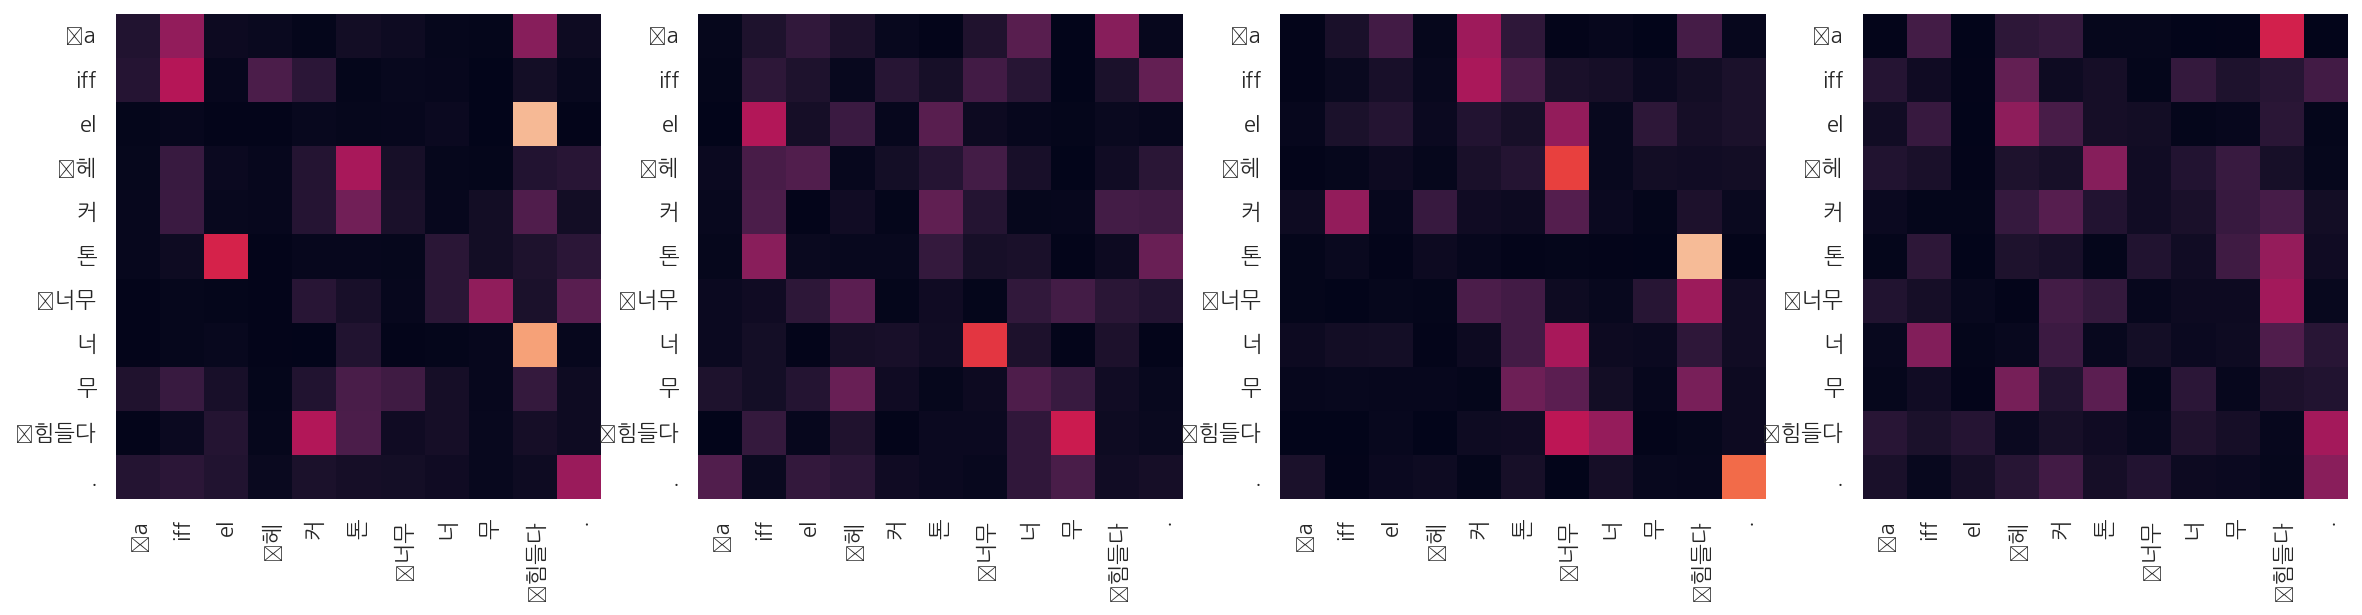

Encoder Layer 2


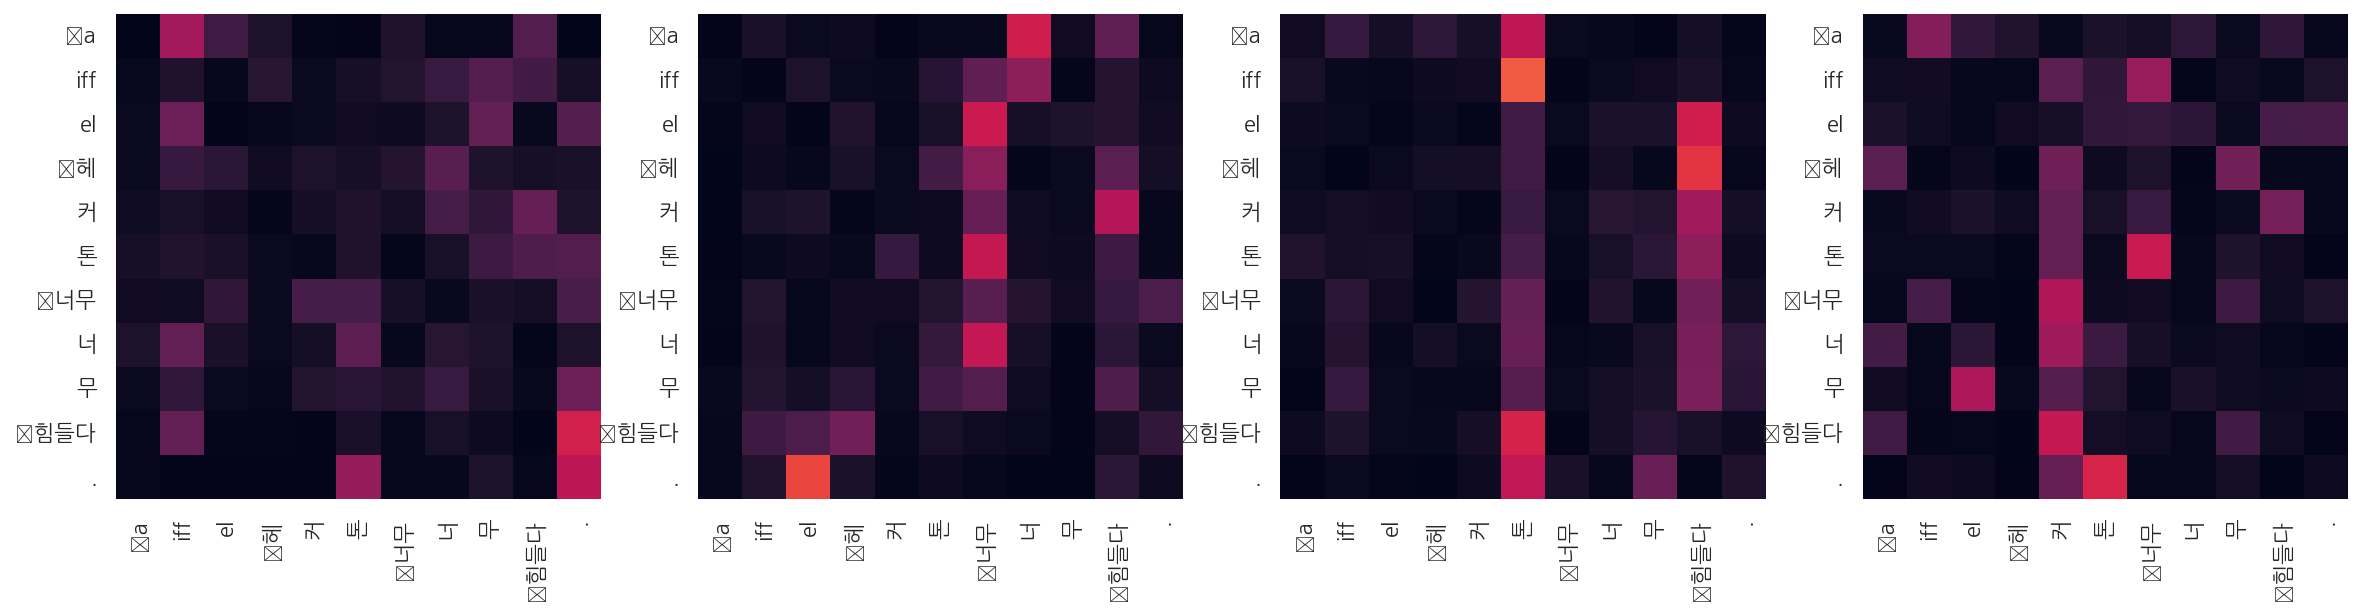

Decoder Self Layer 1


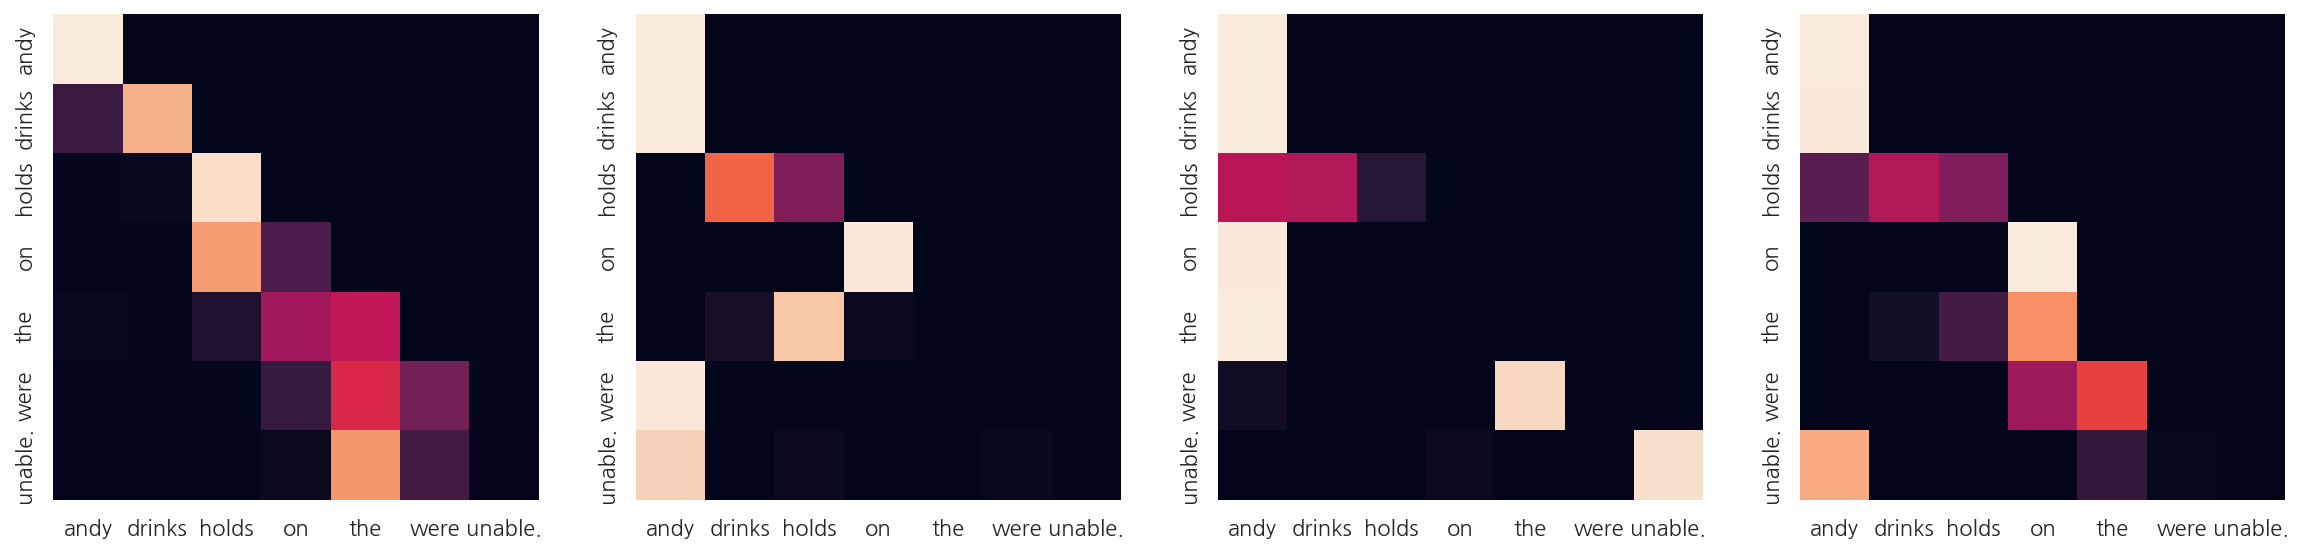

Decoder Src Layer 1


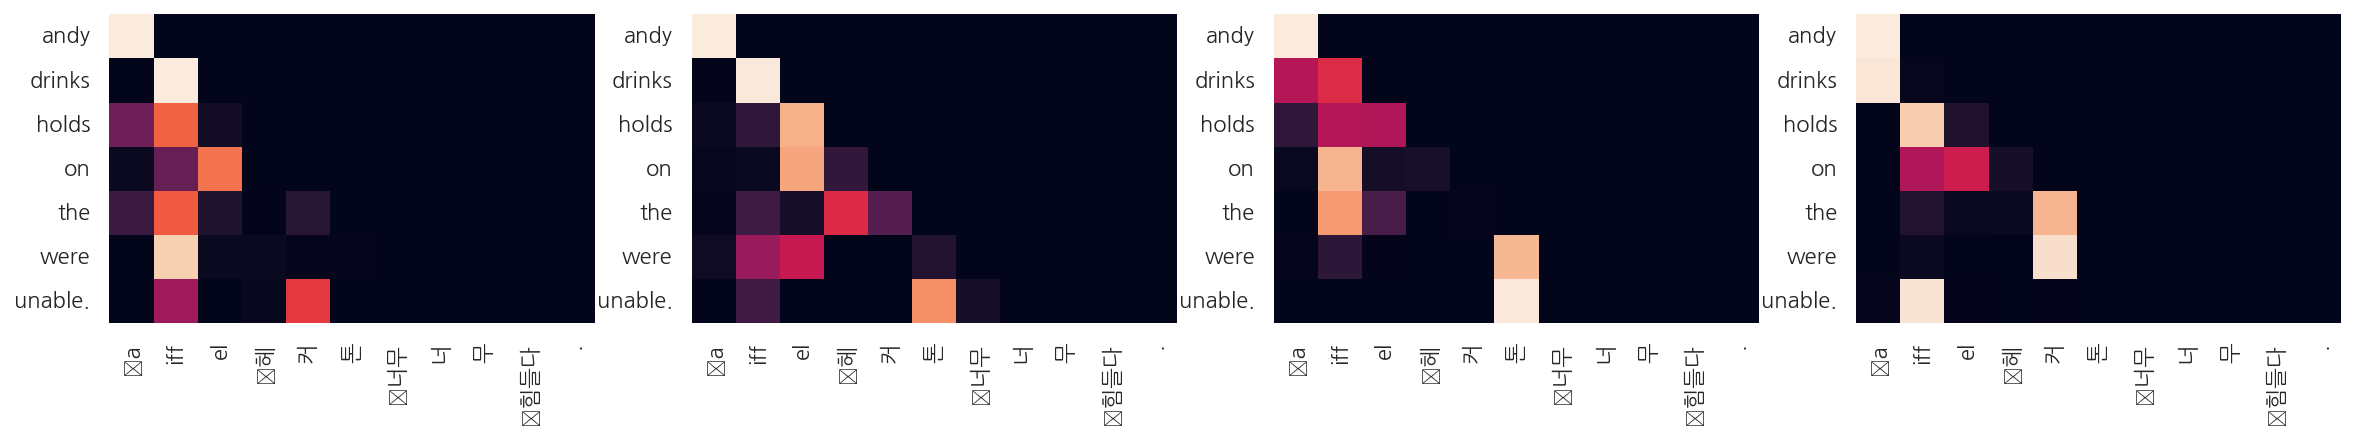

Decoder Self Layer 2


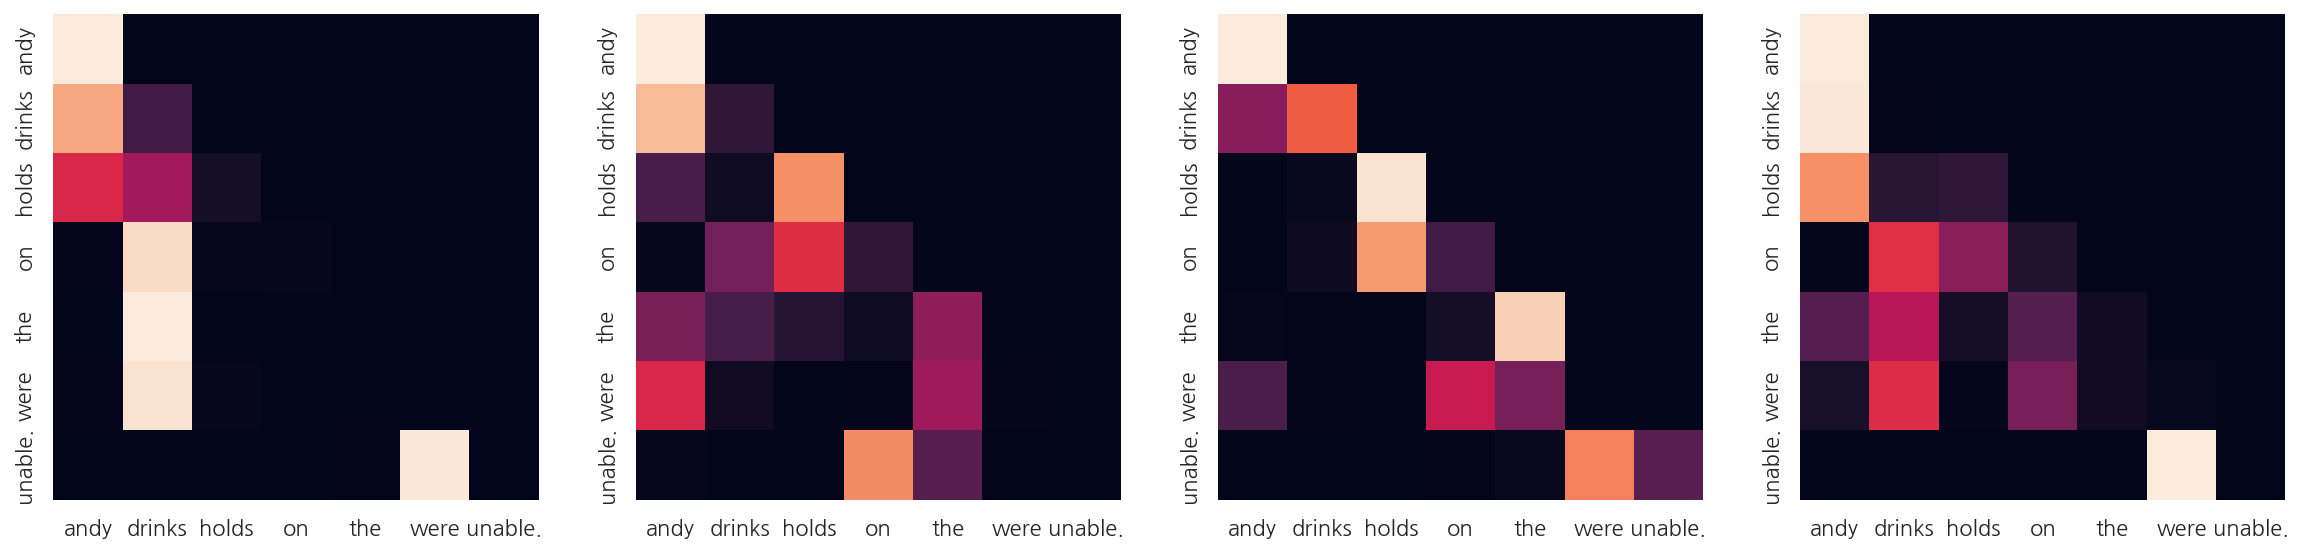

Decoder Src Layer 2


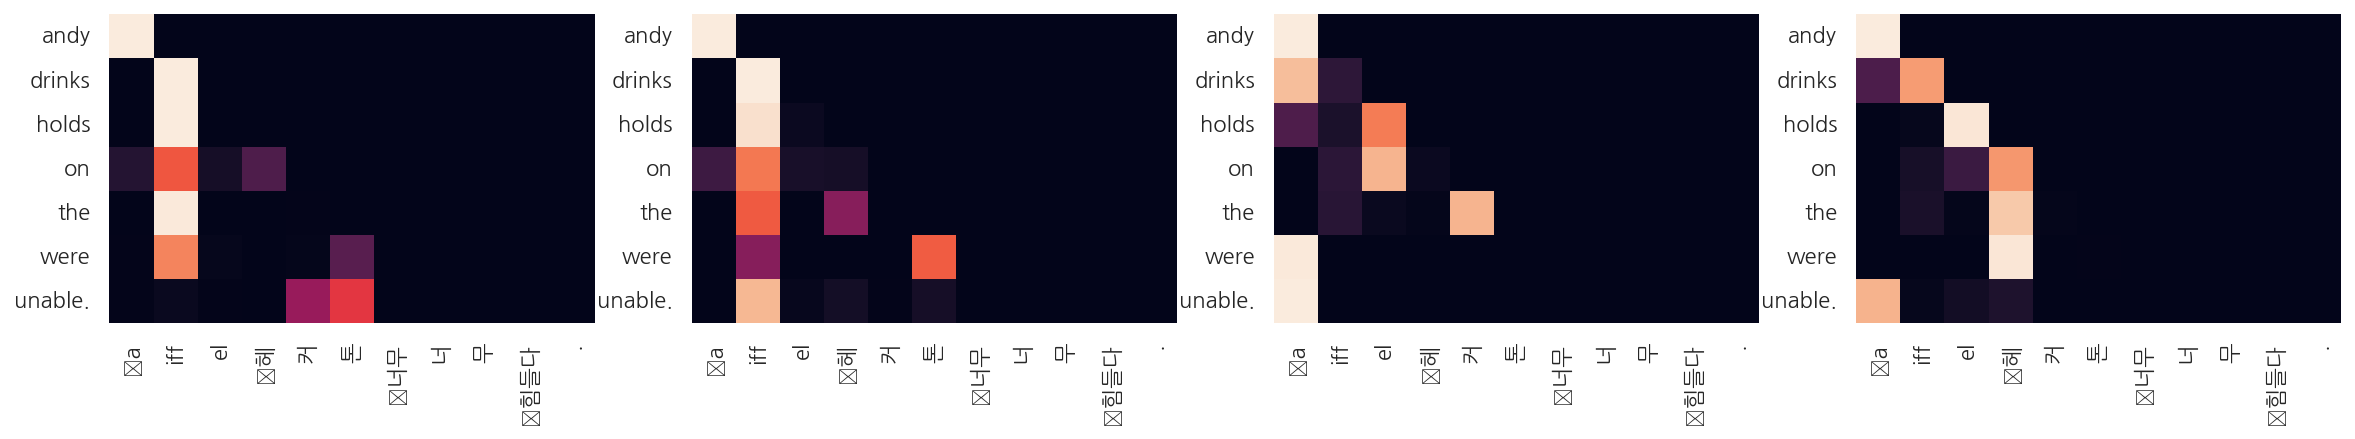

In [34]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다.",
            "투표는 시민의 권리이다",
            "음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.",
            "친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.",
            "박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.",
            "윤석열은 한국의 대통령 이다.",
            "AIFFEL 헤커톤 너무너무 힘들다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
    
    if epoch == EPOCHS -1 : translate(example, transformer, ko_tokenizer, en_tokenizer, True)
        


In [35]:
end_time = time.time()
work_time = round(end_time - start_time)
print(f'총 작업 소요 시간은 약 {work_time}초입니다.')

총 작업 소요 시간은 약 2407초입니다.


# 4. 결과
### Translations
1. 오바마는 대통령이다. 
    > Predicted translation: obama is president.
2. 시민들은 도시 속에 산다. 
    > Predicted translation: citizens part of the san corporate
3. 커피는 필요 없다. 
    > Predicted translation: there s no need to be adopted.
4. 일곱 명의 사망자가 발생했다. 
    > Predicted translation: seven people were killed on saturday.
5. 투표는 시민의 권리이다. 
    > Predicted translation: the only voted a rights.
6. 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다. 
    > Predicted translation: the health care consists of million people over the last decade, as most of which is forecast of the way of last frontier guangdong university.
7. 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다. 
    > Predicted translation: instead, the energy efficient talkings now used his administration to remove itself of energy principles, like the goal of a first round of energy.
8. 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다. 
    > Predicted translation: park had a leading mass posts in the international community, park free former soviet

### Hyperparameters
- n_layers: 2
- d_model: 512
- n_heads: 8
- d_ff: 2048
- dropout: 0.2

### Training Parameters
- Warmup Steps: 4000
- Batch Size: 64
- Epoch At: 19

- 2개의 층만 쌓은 Transformer의 결과는 한국어 문장을 영어 문장으로 완벽히 번역해내지는 못했지만, 문법적으로 왠만큼 잘 들어맞으며 P04에서 실습한 BahdanauAttention model(n_layers: 2, d_model: 512, Batch Size: 64, Epoch At: 10)에 비해 문맥에 어울리는 번역을 해내는 것을 확인할 수 있습니다.
- 논문에서는 인코더와 디코더를 각각 6개를 사용하기 때문에, n_layers를 늘리면 성능이 향상될 것으로 짐작됩니다. 또한 훈련 시간을 줄이기 위해, 토큰의 길이를 임의로 50으로 제한했지만, 길이분포를 분석하여 적절한 토큰 길이를 파악할 수 있습니다. 

|평가문항|상세기준|
|---|---|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.|데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.|
|2. Transformer 번역기 모델이 정상적으로 구동된다.|Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.|

전체적인 학습속도는 빠르다고 느꼈으며 n_layer, vocab_size, batch_size, epochs을 전체적으로 값을 다 올려본다면 더 좋은 성능을 기대할 수 있을 것이라 예상된다.

# 참고
* [딥러닝을 위한 자연어처리 위키독스](https://wikidocs.net/86657)
* [TensorFlow 공식홈페이지 : 언어 이해를 위한 Transfomer 모델](https://www.tensorflow.org/text/tutorials/transformer)